In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import util
import neighborhoodAnalysis as nha
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle
from matplotlib import rc_context

# test plot a dataframe

In [98]:
test_df = pd.read_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd4\001_3.csv',index_col=0)

In [99]:
test_df.head()

,row,col,z,gene,in_immune
42,407,2212,30,001_gene1,False
181,160,1945,9,001_gene1,False
282,636,2022,33,001_gene1,False
289,239,2109,36,001_gene1,False
332,613,2121,15,001_gene1,False


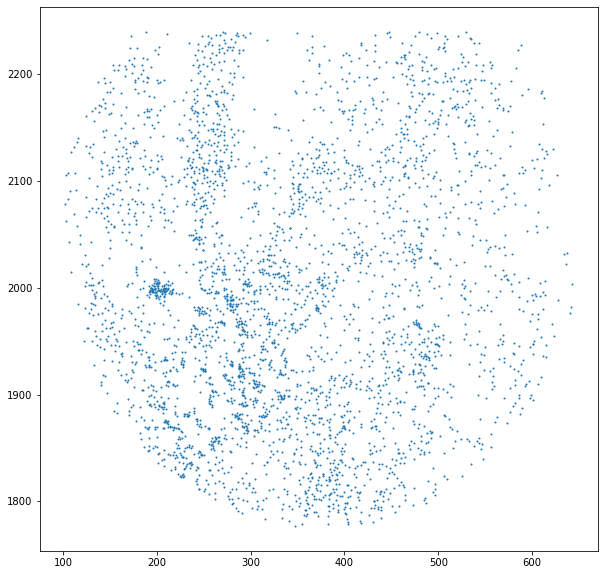

In [100]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(test_df['row'],test_df['col'],s=1)

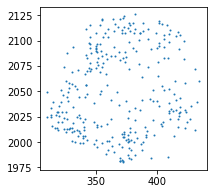

In [101]:
test_immune = test_df[test_df['in_immune'] == True]
fig,ax = plt.subplots(figsize=(3,3))
ax.scatter(test_immune['row'],test_immune['col'],s=1)

# patch by clustering

## test resolution factor

In [102]:
test_envi = test_df
adata = sc.AnnData(X=test_envi[['row','col','z']].values)
adata.obsm['spatial'] = test_envi[['row','col']].values

In [103]:
sc.pp.neighbors(adata)

In [106]:
sc.tl.leiden(adata,resolution=3)

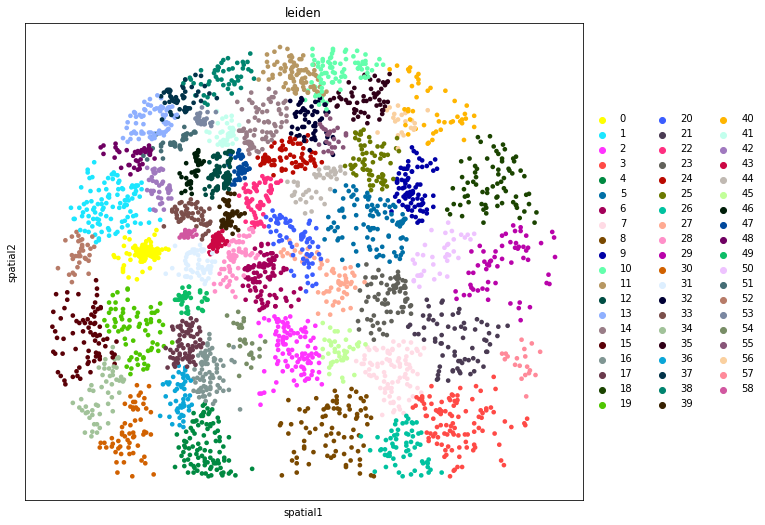

In [107]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata,color=['leiden'],spot_size=5)

## batch processing

In [128]:
cell_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_df\cd8'
cell_l = os.listdir(cell_dir)
cell_l.sort()

In [129]:
def patching(cell):
    cell_df = pd.read_csv(os.path.join(cell_dir,cell),index_col=0)
    envi_df = cell_df[cell_df['in_immune'] == False]
    adata = sc.AnnData(X=cell_df[['row','col','z']].values)
    adata.obsm['spatial'] = cell_df[['row','col']].values
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata,resolution=3)
    adata.write(os.path.join(cell_dir,cell.split('.')[0]+'.h5ad'))
    envi_df.insert(loc=envi_df.shape[1],column='leiden',value=adata.obs['leiden'].values)
    envi_df.to_csv(os.path.join(cell_dir,cell.split('.')[0]+'.csv'))
    return

In [130]:
adata_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\cell_adata\cd8'
patched_df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
os.makedirs(adata_dir,exist_ok=True)
os.makedirs(patched_df_dir,exist_ok=True)
for cell in tqdm(cell_l):
    cell_df = pd.read_csv(os.path.join(cell_dir,cell),index_col=0)
    envi_df = cell_df[cell_df['in_immune'] == False]
    adata = sc.AnnData(X=envi_df[['row','col','z']].values)
    adata.obsm['spatial'] = envi_df[['row','col']].values
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata,resolution=3)
    adata.write(os.path.join(adata_dir,cell.split('.')[0]+'.h5ad'))
    envi_df.insert(loc=envi_df.shape[1],column='leiden',value=adata.obs['leiden'].values)
    envi_df.to_csv(os.path.join(patched_df_dir,cell.split('.')[0]+'.csv'))

100%|██████████| 636/636 [04:14<00:00,  2.50it/s]


# pbmc count

# gnn in single patch

In [131]:
df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
fn_l = os.listdir(df_dir)
fn_l.sort()

In [132]:
network_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proximity\networks\cd8'
z_score_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proximity\z_scores\cd8'
networks_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_pairs\cd8'
os.makedirs(network_dir,exist_ok=True)
os.makedirs(z_score_dir,exist_ok=True)
os.makedirs(networks_dir,exist_ok=True)

In [133]:
# Change gene names
genes = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gene_set.pkl')

In [134]:
def gene_list(cell_df,gene_map):
    genes = cell_df['gene'].tolist()
    fov_l = [int(item.split('_')[0]) for item in genes]
    gene_idx = [item.split('_')[-1] for item in genes]
    gene_name = []
    for i in range(len(genes)):
        set = 'set1'
        if fov_l[i] < 30:
            set = 'set1'
        elif fov_l[i] < 60:
            set = 'set2'
        elif fov_l[i] < 90:
            set = 'set3'
        else:
            set = 'set4'
        gene_name.append(gene_map[set][gene_idx[i]])
    return gene_name

In [135]:
def proximity(fn):
    if fn.endswith('.csv'):
        cell_id = fn.split('.')[0]
        
        cell_df = pd.read_csv(os.path.join(df_dir,fn))
        gene_names = gene_list(cell_df,genes)
        cell_df.insert(loc=cell_df.shape[1],column='gene_name',value=gene_names)
        cell_by_patch = cell_df.groupby('leiden')
        
        patches = np.sort(cell_df['leiden'].unique())
        interaction_l = Parallel(n_jobs=4)(delayed(nha.permutation_3d)(cell_by_patch.get_group(i),5,'row',
                                                                       'col','z','gene_name',500) for i in patches)
        with open(os.path.join(network_dir,cell_id+'.pkl'),'wb') as f:
            pickle.dump(interaction_l, f)
        
        patch_count = util.counting(cell_df,count_by='leiden',gene_name='gene_name')
        patch_count.drop(columns=['Count_id'],inplace=True)
        patch_z_scores = (patch_count - patch_count.mean()) / patch_count.std()
        with open(os.path.join(z_score_dir,cell_id+'.pkl'),'wb') as f:
            pickle.dump(patch_z_scores,f)
        
        connected_pairs = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(cell_by_patch.get_group(i),
                                                                       5,'row','col','z') for i in patches)
        with open(os.path.join(networks_dir,cell_id+'.pkl'),'wb') as f:
            pickle.dump(connected_pairs,f)

In [136]:
_ = Parallel(n_jobs=-2,verbose=64)(delayed(proximity)(fn) for fn in fn_l)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:  2

In [137]:
# After classification, find explanable features, link to mechanistic understanding

# Generate network of patches

## Find connected patches

In [138]:
df_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\patched_cell_df\cd8'
fn_l = os.listdir(df_dir)
fn_l.sort()

In [139]:
gene_set1 = []
gene_set2 = []
gene_set3 = []
gene_set4 = []
for fn in tqdm(fn_l):
    fov = fn.split('_')[0]
    cell_df = pd.read_csv(os.path.join(df_dir,fn))
    df_by_patch = cell_df.groupby('leiden')
    patch_center = df_by_patch.mean()[['row','col','z']]
    patch_id = []
    cell_id = fn.split('.')[0]
    for i in range(len(patch_center)):
        patch_id.append(cell_id+'_'+str(i))
    patch_center.insert(loc=patch_center.shape[1],column='patch_id',value=patch_id)
    patch_center.insert(loc=patch_center.shape[1],column='cellID',value=[cell_id]*patch_center.shape[0])
    patch_center.reset_index(drop=True,inplace=True)
    temp = int(fov)
    if temp < 30:
        gene_set1.append(patch_center)
    elif temp < 60:
        gene_set2.append(patch_center)
    elif temp < 90:
        gene_set3.append(patch_center)
    else:
        gene_set4.append(patch_center)

100%|██████████| 636/636 [00:10<00:00, 58.13it/s] 


In [140]:
gene_set1 = pd.concat(gene_set1)
gene_set1.reset_index(drop=True,inplace=True)

gene_set2 = pd.concat(gene_set2)
gene_set2.reset_index(drop=True,inplace=True)

gene_set3 = pd.concat(gene_set3)
gene_set3.reset_index(drop=True,inplace=True)

gene_set4 = pd.concat(gene_set4)
gene_set4.reset_index(drop=True,inplace=True)

In [141]:
set1_by_cell = gene_set1.groupby('cellID')
cells = list(np.sort(gene_set1['cellID'].unique()))
connected_pairs1 = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(set1_by_cell.get_group(i),
                                                                        5,'row','col','z') for i in cells)

set2_by_cell = gene_set2.groupby('cellID')
cells = list(np.sort(gene_set2['cellID'].unique()))
connected_pairs2 = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(set2_by_cell.get_group(i),
                                                                        5,'row','col','z') for i in cells)

set3_by_cell = gene_set3.groupby('cellID')
cells = list(np.sort(gene_set3['cellID'].unique()))
connected_pairs3 = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(set3_by_cell.get_group(i),
                                                                        5,'row','col','z') for i in cells)

set4_by_cell = gene_set4.groupby('cellID')
cells = list(np.sort(gene_set4['cellID'].unique()))
connected_pairs4 = Parallel(n_jobs=4)(delayed(nha.find_connected_pairs)(set4_by_cell.get_group(i),
                                                                        5,'row','col','z') for i in cells)

In [142]:
out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_patches\cd8'
os.makedirs(out_dir,exist_ok=True)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_patches\cd8\set1.pkl','wb') as f:
    pickle.dump(connected_pairs1,f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_patches\cd8\set2.pkl','wb') as f:
    pickle.dump(connected_pairs2,f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_patches\cd8\set3.pkl','wb') as f:
    pickle.dump(connected_pairs3,f)
with open(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\connected_patches\cd8\set4.pkl','wb') as f:
    pickle.dump(connected_pairs4,f)

In [143]:
out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8'
os.makedirs(out_dir,exist_ok=True)
gene_set1.to_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set1_centers.csv')
gene_set2.to_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set2_centers.csv')
gene_set3.to_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set3_centers.csv')
gene_set4.to_csv(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\patch_centers\cd8\set4_centers.csv')

## Find proximity score dataframe

In [144]:
proxi_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proximity\networks\cd8'
proxi_l = os.listdir(proxi_dir)
proxi_l.sort()

In [145]:
gene_sets = pd.read_pickle(r'..\..\coculture_diagonal\primed_pbmc\00_analysis\gene_set.pkl')
gene_pairs1 = []
for g1 in list(gene_sets['set1'].values()):
    for g2 in list(gene_sets['set1'].values()):
        if g1 != g2 and g1+'_'+g2 not in gene_pairs1 and g2+'_'+g1 not in gene_pairs1:
            gene_pairs1.append(g1+'_'+g2)

gene_pairs2 = []
for g1 in list(gene_sets['set2'].values()):
    for g2 in list(gene_sets['set2'].values()):
        if g1 != g2 and g1+'_'+g2 not in gene_pairs2 and g2+'_'+g1 not in gene_pairs2:
            gene_pairs2.append(g1+'_'+g2)

gene_pairs3 = []
for g1 in list(gene_sets['set3'].values()):
    for g2 in list(gene_sets['set3'].values()):
        if g1 != g2 and g1+'_'+g2 not in gene_pairs3 and g2+'_'+g1 not in gene_pairs3:
            gene_pairs3.append(g1+'_'+g2)

gene_pairs4 = []
for g1 in list(gene_sets['set4'].values()):
    for g2 in list(gene_sets['set4'].values()):
        if g1 != g2 and g1+'_'+g2 not in gene_pairs4 and g2+'_'+g1 not in gene_pairs4:
            gene_pairs4.append(g1+'_'+g2)

In [146]:
proximity1 = {}
for pair in gene_pairs1:
    proximity1[pair] = []
proximity2 = {}
for pair in gene_pairs2:
    proximity2[pair] = []
proximity3 = {}
for pair in gene_pairs3:
    proximity3[pair] = []
proximity4 = {}
for pair in gene_pairs4:
    proximity4[pair] = []

for fn in tqdm(proxi_l):
    if fn.endswith('.pkl'):
        proxi = pd.read_pickle(os.path.join(proxi_dir,fn))
        cell_id = fn.split('.')[0]
        fov = int(cell_id.split('_')[0])
        if fov < 30:
            for pair in gene_pairs1:
                g1,g2 = pair.split('_')
                for i in range(len(proxi)):
                    if not g1 in proxi[i][0].index or not g2 in proxi[i][0].index:
                        proximity1[pair].append(0)
                    else:
                        proximity1[pair].append(proxi[i][0].loc[g1,g2])
        elif fov < 60:
            for pair in gene_pairs2:
                g1,g2 = pair.split('_')
                for i in range(len(proxi)):
                    if not g1 in proxi[i][0].index or not g2 in proxi[i][0].index:
                        proximity2[pair].append(0)
                    else:
                        proximity2[pair].append(proxi[i][0].loc[g1,g2])
        elif fov < 90:
            for pair in gene_pairs3:
                g1,g2 = pair.split('_')
                for i in range(len(proxi)):
                    if not g1 in proxi[i][0].index or not g2 in proxi[i][0].index:
                        proximity3[pair].append(0)
                    else:
                        proximity3[pair].append(proxi[i][0].loc[g1,g2])
        else:
            for pair in gene_pairs4:
                g1,g2 = pair.split('_')
                for i in range(len(proxi)):
                    if not g1 in proxi[i][0].index or not g2 in proxi[i][0].index:
                        proximity4[pair].append(0)
                    else:
                        proximity4[pair].append(proxi[i][0].loc[g1,g2])

  0%|          | 0/636 [00:00<?, ?it/s]

100%|██████████| 636/636 [00:21<00:00, 29.59it/s]


In [147]:
proximity1_df = pd.DataFrame(proximity1)
proximity2_df = pd.DataFrame(proximity2)
proximity3_df = pd.DataFrame(proximity3)
proximity4_df = pd.DataFrame(proximity4)

In [148]:
out_dir = r'..\..\coculture_diagonal\primed_pbmc\00_analysis\networks\proxi_dfs\cd8'
os.makedirs(out_dir,exist_ok=True)
proximity1_df.to_csv(os.path.join(out_dir, 'set1.csv'))
proximity2_df.to_csv(os.path.join(out_dir, 'set2.csv'))
proximity3_df.to_csv(os.path.join(out_dir, 'set3.csv'))
proximity4_df.to_csv(os.path.join(out_dir, 'set4.csv'))